In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#define the models
class DebugLayer(nn.Module):
    def __init__(self, log):
        super(DebugLayer, self).__init__()
        self.log = log
    
    def forward(self, x):
        print(self.log)
        print(x.shape)
        return x
    
class netG(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(netG, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        
        self.mainModule = nn.Sequential(
            #DebugLayer("gen input"),
            nn.Linear(self.inputSize, self.hiddenSize, bias=True),
            #DebugLayer("gen first lin"),
            nn.Softplus(),
            #DebugLayer("gen first sf"),
            nn.Linear(self.hiddenSize, self.outputSize, bias=True),
            #DebugLayer("gen second lin"),
            nn.Softplus(),
            #DebugLayer("gen second sf"),
        )
        
    def forward(self, x):
        return self.mainModule(x.view(-1,self.inputSize))


class netD(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(netD, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize

        self.mainModule = nn.Sequential(
            #DebugLayer("disc input"),
            nn.Linear(self.inputSize, self.hiddenSize, bias=True),
            #DebugLayer("disc first lin"),
            nn.Tanh(),
            #DebugLayer("disc tanh"),
            nn.Linear(self.hiddenSize, 1, bias=True),
            #DebugLayer("disc second lin"),
        )
        
    def forward(self, x):
        return self.mainModule(x.view(-1,self.inputSize))

def adversarial_trainer( 
    train_loader, 
    noise_loader,
    generator, 
    discriminator, 
    epochs=5,
    learningRate=0.001,
    criterion=nn.BCELoss(),
    clampLower=-0.01,
    clampHigher=0.01,
    Diters=5,
    Giters=1,
    printEpochs=10
):
    inputSize, outputSize = generator.inputSize, generator.outputSize
    
    optimizerD = optim.RMSprop(discriminator.parameters(), lr=learningRate)
    optimizerG = optim.RMSprop(generator.parameters(), lr=learningRate)
    
    my_dpi = 96
    plt.figure(figsize=(1200/my_dpi, 600/my_dpi), dpi=my_dpi)
    true, false = 1, 0
    one = torch.tensor(1, dtype=torch.float)
    mone = one * -1
    
    dRealErr = []
    dFakeErr = []
    gErr = []
    
    for epoch in range(epochs):
        for batch, ([ft], [noise]) in enumerate(zip(train_loader, noise_loader)):
            ft = ft.squeeze().to(device)
            noise = noise.to(device)

            for disc_ep in range(Diters):
                for p in discriminator.parameters():
                    p.data.clamp_(clampLower, 
                                  clampHigher)


                # discriminator gradient with real data
                discriminator.zero_grad()
                out_d = discriminator.forward(ft)

                err_D_real = out_d.mean()
                err_D_real.backward(one)

                # discriminator gradient with generated data
                
                out_g = generator.forward(noise)
                out_d_g = discriminator.forward(Variable(out_g.data))
                err_D_fake = out_d_g.mean()
                err_D_fake.backward(mone)

                err_D = err_D_real - err_D_fake
                optimizerD.step()

            # generator gradient
            for gEpoch in range(Giters):
                generator.zero_grad()
                out_h_data = discriminator.forward(ft)    
                out_h_g = discriminator.forward(out_g) 
                #err_G = ((out_h_data.mean(0) - out_h_g.mean(0))**2).sum()
                err_G = torch.mean(out_h_g)
                err_G.backward()

                optimizerG.step()
                
            dRealErr.append(err_D_real.cpu().detach().numpy())
            dFakeErr.append(err_D_fake.cpu().detach().numpy())
            gErr.append(err_G.mean().cpu().detach().numpy())

        # show the current generated output
        if (epoch + 1) % printEpochs == 0:
            fig, axs = plt.subplots(3)
            axs[0].plot(dRealErr)
            axs[1].plot(dFakeErr)
            axs[2].plot(gErr)
            
            print("\nEpoch {}".format(epoch))
            plt.show()
            
            print("\nGenerated example:")
            
            
            fig, axs = plt.subplots(2,2)
            
            axs[0][0].plot(generator.forward(noise).cpu().detach().numpy()[0])
            axs[0][1].plot(generator.forward(noise).cpu().detach().numpy()[1])
            axs[1][0].plot(generator.forward(noise).cpu().detach().numpy()[2])
            axs[1][1].plot(generator.forward(noise).cpu().detach().numpy()[3])
            plt.show()

            print("err_d {}".format(out_d.mean()))
            print("err_d_g {}".format(out_d_g.mean()))
            print("err_G {}".format(err_G.mean()))

In [3]:
#preprocessing


def checkSpikeLocations():
    gt = scipy.io.loadmat('../data/gen/ground_truth.mat')
    sim = scipy.io.loadmat('../data/gen/simulation_1.mat')
    print(gt["spike_first_sample"][0][0].shape)
    print(gt["su_waveforms"][0][0].shape)
    print(gt["spike_classes"][0][0].shape)


    print(gt["spike_first_sample"][0][0][0][0])
    print(gt["spike_classes"][0][0][0][1])

    first_spike_start = gt["spike_first_sample"][0][0][0][0]
    first_spike_class = gt["spike_classes"][0][0][0][1]

    data = sim["data"][0][first_spike_start : first_spike_start + 80]

    waveform = gt["su_waveforms"][0][0][first_spike_class]

    fig, axs = plt.subplots(2)
    fig.suptitle('Single unit waveform vs. Simulated signal')
    axs[0].plot(range(0,316), waveform)
    axs[1].plot(range(0,80), data)

    plt.show()

def splitSim(simNo):
    gt = scipy.io.loadmat('../data/gen/ground_truth.mat')
    sim = scipy.io.loadmat('../data/gen/simulation_{}.mat'.format(simNo))

    data = sim["data"][0]
    firstSamples = gt["spike_first_sample"][0][simNo - 1][0]

    spikes = []
    hash = []

    simIndex = 0
    spikeIndex = 0
    sampleNumber = len(data)
    spikeNumber = len(firstSamples)
    spikeLength = 79 # 316 at 96k Hz downsampled to 24k Hz

    while simIndex < sampleNumber:
        if spikeIndex < spikeNumber: # I still have spikes 
            if simIndex < firstSamples[spikeIndex]: # a non-spike interfal follows
                hash.append(data[simIndex : firstSamples[spikeIndex]])
                simIndex = firstSamples[spikeIndex]
            else: # I have a spike
                spikes.append(data[simIndex : simIndex + spikeLength])
                simIndex += spikeLength
                spikeIndex += 1
        else: # No more spikes; might still have hash
            hash.append(data[simIndex:])
            simIndex = sampleNumber

    return (np.array(spikes), np.array(hash, dtype=object))



In [203]:
def gen_loaders(L1, batchsize):
    
    spikes, bg = splitSim(1)
    
    background = []
    
    for chunk in bg:
        i = 0
        sample = []
        while i < len(chunk):
            sample.append(chunk[i])
            i += 1
            if i % 79 == 0:
                background.append(sample)
                sample = []
                
    background = np.array(background)

    
    gt = scipy.io.loadmat('../data/gen/ground_truth.mat')
    
    testsim = scipy.io.loadmat('../data/gen/simulation_11.mat')
    testdata = testsim["data"][0][0:20000]
    testfirstSamples = gt["spike_first_sample"][0][11 - 1][0]
    valsim = scipy.io.loadmat('../data/gen/simulation_12.mat')
    valdata = valsim["data"][0][0:20000]
    valfirstSamples = gt["spike_first_sample"][0][12 - 1][0]

    vd = []
    vl = []
    spikeIndex = 0
    for index in range(0, len(valdata) - 79):
        vd.append(valdata[index:index + 79])
        if index != valfirstSamples[spikeIndex]:
            vl.append(0)
        else:
            vl.append(1)
            spikeIndex += 1
            
    valdata = []
    vallabel = []
    offset = 2
    for i,x in enumerate(vl):
        if x == 1:
            for j in range(i - offset, i):
                valdata.append(vd[j])
                vallabel.append(0)
                
            valdata.append(vd[i])
            vallabel.append(1)
            
            for j in range(i + 1, i + offset + 1):
                valdata.append(vd[j])
                vallabel.append(0)
            
            for j in range(i + 100, i + 100 + 4):
                valdata.append(vd[j])
                vallabel.append(0)
            
    valdata = np.array(valdata)
    vallabel = np.array(vallabel)
            
    td = []
    tl = []
    spikeIndex = 0
    for index in range(0, len(testdata) - 79):
        td.append(testdata[index:index + 79])
        if index != testfirstSamples[spikeIndex]:
            tl.append(0)
        else:
            tl.append(1)
            spikeIndex += 1
            
            
            
    testdata = []
    testlabel = []
    for i,x in enumerate(tl):
        if x == 1:
            for j in range(i - offset, i):
                testdata.append(td[j])
                testlabel.append(0)
                
            testdata.append(td[i])
            testlabel.append(1)
            
            for j in range(i + 1, i + offset + 1):
                testdata.append(td[j])
                testlabel.append(0)
            
            for j in range(i + 100, i + 100 + 4):
                testdata.append(td[j])
                testlabel.append(0)
            
    testdata = np.array(testdata)
    testlabel = np.array(testlabel)
    
    n1 = torch.randn(len(spikes), L1) 
    n2 = torch.randn(len(background), L1) 
    n1 = data_utils.TensorDataset(n1)
    n2 = data_utils.TensorDataset(n2)  
    
    spikes = torch.from_numpy(spikes).float()
    background = torch.from_numpy(background).float()
    valdata = torch.from_numpy(valdata).float()
    testdata = torch.from_numpy(testdata).float()
    
    sim_val        = data_utils.TensorDataset(valdata)
    sim_test        = data_utils.TensorDataset(testdata)
    spike_dataset      = data_utils.TensorDataset(spikes)
    background_dataset = data_utils.TensorDataset(background)
    
    noise1 = data_utils.DataLoader(n1, batch_size=batchsize, shuffle=False)
    noise2 = data_utils.DataLoader(n2, batch_size=batchsize, shuffle=False)
    loader1 = data_utils.DataLoader(spike_dataset, batch_size=batchsize, shuffle=False)
    loader2 = data_utils.DataLoader(background_dataset, batch_size=batchsize, shuffle=False)
    loader_mix_test = data_utils.DataLoader(sim_test, shuffle=False)
    loader_mix_val = data_utils.DataLoader(sim_val, shuffle=False)

    return noise1, noise2, loader1, loader2, loader_mix_val, vallabel, loader_mix_test, testlabel

In [204]:
batchSize = 1000
noise1, noise2, loader1, loader2, loader_mix_val, vallabel, loader_mix_test, testlabel  = gen_loaders(
    200, batchSize)

Spike generator training

Epoch 49


<Figure size 1200x600 with 0 Axes>

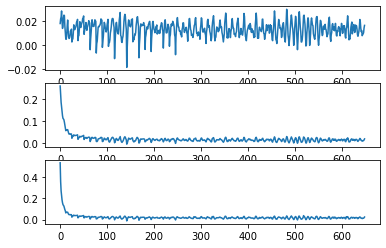


Generated example:


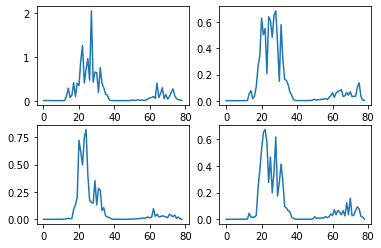

err_d 0.01621970534324646
err_d_g 0.020003000274300575
err_G 0.02389630675315857


In [94]:
gen1 = netG(inputSize=200, hiddenSize=50, outputSize=79).to(device)
disc1 = netD(inputSize=79, hiddenSize=50).to(device)

print("Spike generator training")

adversarial_trainer( 
    train_loader=loader1, 
    noise_loader=noise1,
    generator=gen1, 
    discriminator=disc1, 
    epochs=50,
    learningRate=0.001,
    criterion=nn.BCELoss(),
    Diters=5,
    Giters=1,
    printEpochs = 50
)

Background generator training

Epoch 4


<Figure size 1200x600 with 0 Axes>

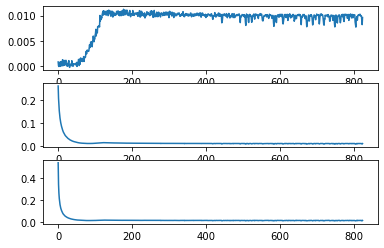


Generated example:


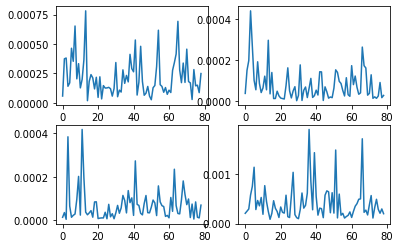

err_d 0.009622110985219479
err_d_g 0.010287981480360031
err_G 0.011866487562656403


In [95]:
gen2 = netG(inputSize=200, hiddenSize=50, outputSize=79).to(device)
disc2 = netD(inputSize=79, hiddenSize=50).to(device)
print("Background generator training")

adversarial_trainer( 
    train_loader=loader2, 
    noise_loader=noise2,
    generator=gen2, 
    discriminator=disc2, 
    epochs=5,
    learningRate=0.001,
    criterion=nn.BCELoss(),
    Diters=5,
    Giters=1,
    printEpochs = 5
)

In [163]:
def maxlikelihood_separatesources(
    generators,
    loader_mix, 
    epochs=5
):
    generator1, generator2 = generators
    inputSize, outputSize = generator1.inputSize, generator1.outputSize
    
    x1hat, x2hat = [], []
    mixes = []
    for i, [mix] in enumerate(loader_mix): 
        mix = mix.squeeze().view(-1,79).to(device)
        print('Processing source ',i)
        Nmix = mix.size(0)
        x1 = Variable(torch.rand(Nmix, inputSize, device=device), requires_grad=True)
        x2 = Variable(torch.rand(Nmix, inputSize, device=device), requires_grad=True)

        optimizer_sourcesep = optim.Adam([x1, x2], lr=1e-3, betas=(0.5, 0.999))
        for epoch in range(epochs):
           
            mix_sum = generator1.forward(x1) + generator2.forward(x2) 
            #Poisson
            eps = 1e-20
            err = torch.mean(-Variable(mix)*torch.log(mix_sum+eps) + mix_sum)

            err.backward()

            optimizer_sourcesep.step()

            x1.grad.data.zero_()
            x2.grad.data.zero_()

            #print('Step in epoch [{:d}\{:d}]'.format(epoch+1, epochs))
            #print('The error is ', err)
        x1hat.append(generator1.forward(x1).data.cpu().numpy())
        x2hat.append(generator2.forward(x2).data.cpu().numpy())
        mixes.append(mix.cpu().numpy())
    
    fig, axs = plt.subplots(4,3)
    
    for i in range(0,4):
        axs[i][0].plot(x1hat[i][0])
        axs[i][0].title.set_text('Estimated Source 1')
        axs[i][1].plot(x2hat[i][0])
        axs[i][1].title.set_text('Estimated Source 2')
        axs[i][2].plot(mixes[i][0])
        axs[i][2].title.set_text('Mixture')

    plt.show()
    
    return x1hat

Processing source  0
Processing source  1
Processing source  2
Processing source  3
Processing source  4
Processing source  5
Processing source  6
Processing source  7
Processing source  8
Processing source  9
Processing source  10
Processing source  11
Processing source  12
Processing source  13
Processing source  14
Processing source  15
Processing source  16
Processing source  17
Processing source  18
Processing source  19
Processing source  20
Processing source  21
Processing source  22
Processing source  23
Processing source  24
Processing source  25
Processing source  26
Processing source  27
Processing source  28
Processing source  29
Processing source  30
Processing source  31
Processing source  32
Processing source  33
Processing source  34
Processing source  35
Processing source  36
Processing source  37
Processing source  38
Processing source  39
Processing source  40
Processing source  41
Processing source  42
Processing source  43
Processing source  44
Processing source  4

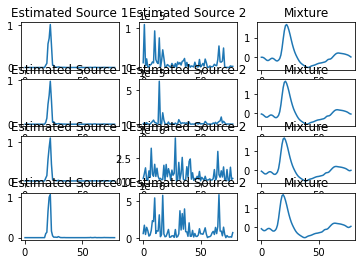

In [205]:
cleanextractedSpikesValidation = maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=loader_mix_val,
    epochs=500
)

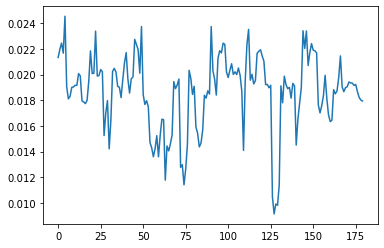

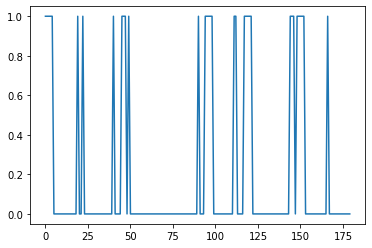

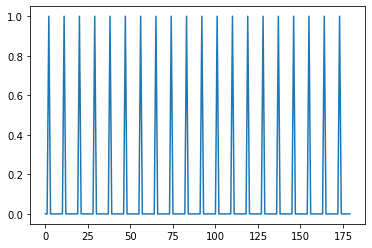

In [206]:
out = []

extractedSpikesValidation = np.array(cleanextractedSpikesValidation)
extractedSpikesValidation = torch.from_numpy(extractedSpikesValidation).float().to(device)


for [window] in extractedSpikesValidation:
    out.append(disc1.forward(window).data.cpu().numpy())

out = np.array(out).flatten()

treshold = 0.021

res = []

for i in out:
    if i >= treshold:
        res.append(1)
    else:
        res.append(0)
        
plt.plot(out)
plt.show()

plt.plot(res)
plt.show()

plt.plot(vallabel)
plt.show()

In [209]:
truepos = 0
falsepos = 0
trueneg = 0
falseneg = 0

for i in range(0, len(vallabel)):
    if vallabel[i] == 1:
        if res[i] == 1:
            truepos += 1
        else:
            falseneg += 1
    else:
        if res[i] == 1:
            falsepos += 1
        else:
            trueneg += 1
            
print(truepos + falsepos + trueneg + falseneg)
print(len(vallabel))

print("Precision: {}".format(truepos / (truepos + falsepos)))
print("Recal: {}".format(truepos / (truepos + falseneg)))

180
180
Precision: 0.11764705882352941
Recal: 0.2
